In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

In [2]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import extinction as extinction

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,feh,am,distance,isochrones):
        
        '''
        feh: [float] metallicity of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = feh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.jlabel = 'Jmag'
        self.hlabel = 'Hmag'
        self.klabel = 'Ksmag'
        self.uniq_ages = 10**np.unique(isochrones['logAge'])/10**9
        self.iso = isochrones
        
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
    
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        data = data[np.where(data!=close1)]
    
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def wang_alav(self,wave):
        '''
        Calculate the relative extinction to Av accoding to Wang et al. 2019
    
        Input:
        -----
            wave: effective wavelength in microns of the passband
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x = 1/wave 
        if 0.3 <= x < 1.0:
            y = x - 1.82
            alav = (1.0+0.7499*y-0.1086*(y**2)-0.08909*(y**3)+0.02905*(y**4)+
                    0.01069*(y**5)+0.001707*(y**6)-0.001002*(y**7))
            return alav
    
        elif 1.0 <= x < 3.33:
            #0.3722 +/- 0.0026; -2.070 +/- 0.030
            alav = 0.3722*(wave**-2.070)
            return alav
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            al: extinction in the same band used to initialize the class
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        ajak = self.wang_alav(self.leff['J'])/self.wang_alav(self.leff['K'])
        ahak = self.wang_alav(self.leff['H'])/self.wang_alav(self.leff['K'])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
            print('in: ',age)
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            if (lgteff > min(slogTe) & lgteff < max(slogTe)):
                j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
                h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
                k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            
                j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ajak
                h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*ahak
                k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            
                print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
                print('ak: {:.3f}'.format(ak))
                print('---')
            
                return j_app,h_app,k_app
            
            else:
                return -9999.0,-9999.0,-9999.0
            
        else:
            age_lo,age_hi = self.neighbors(self.uniq_ages,age)
            
            print('age: ',age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==self.closest(self.iso['logAge'],
                                                                         np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==self.closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            if (lgteff > min(slogTe_lo) & lgteff < max(slogTe)):
                j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
                h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
                k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            
                # Calculate the theoretical apparent magnitude
                j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ajak
                h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*ahak
                k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            
                print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
                print('ak: {:.3f}'.format(ak))
                print('---')
            
                return j_app,h_app,k_app
            
            else:
                return -9999.0,-9999.0,-9999.0

# Parsec

In [3]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [4]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [7]:
gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

(array([ 18.,  81., 146., 221., 341., 479., 542., 192.,  28.,   6.]),
 array([0.76001394, 0.7947456 , 0.8294773 , 0.864209  , 0.8989407 ,
        0.93367237, 0.96840405, 1.0031357 , 1.0378674 , 1.0725992 ,
        1.1073308 ], dtype=float32),
 <a list of 10 Patch objects>)

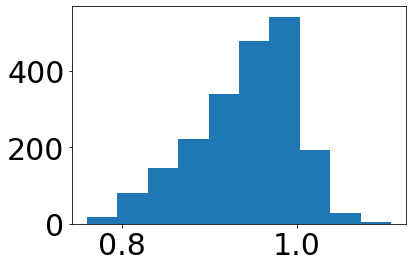

In [8]:
plt.hist(gcs['TEFF']/5040)

# Test Code

In [5]:
from scipy.optimize import curve_fit

In [6]:
# pick star
g_idx = 1000

# initialize class
CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx],10400,massive)

# curve_fit does its thing
popt, pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][g_idx],
                         np.array([[gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]]],dtype=float).T.ravel(),
                         p0=[13.75,gcs['AK_TARG'][g_idx]],bounds=((0.,0.),(14.,1.)),method='dogbox')


print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]))
print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx]))
print('Final Calculated [Age, Ak]:',popt)

age:  13.75


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [12]:
m3_idx = np.where(gcs['CLUSTER']=='M3')

m3ages = []
m3ak = []
for i in np.squeeze(m3_idx):
    CalcAgeM3 = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],10400,massive)
    popt, _ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][i],
                         np.array([[gcs['J'][i],gcs['H'][i],gcs['K'][i]]],dtype=float).T.ravel(),
                         p0=[13.75,gcs['AK_TARG'][i]],bounds=((0.,0.),(14.,1.)),method='dogbox')
    m3ages.append(popt[0])
    m3ak.append(popt[1])

age:  13.75
Calculated Apparent J: 11.954 H: 11.340 K: 11.245
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.954 H: 11.340 K: 11.245
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.954 H: 11.340 K: 11.245
ak: 0.004
---
age:  14.0
Calculated Apparent J: 12.153 H: 11.454 K: 11.311
ak: 0.059
---
age:  13.999999791383743
Calculated Apparent J: 12.153 H: 11.454 K: 11.311
ak: 0.059
---
age:  14.0
Calculated Apparent J: 12.153 H: 11.454 K: 11.311
ak: 0.059
---
age:  14.0
Calculated Apparent J: 12.146 H: 11.450 K: 11.309
ak: 0.057
---
age:  13.999999791383743
Calculated Apparent J: 12.146 H: 11.450 K: 11.309
ak: 0.057
---
age:  14.0
Calculated Apparent J: 12.146 H: 11.450 K: 11.309
ak: 0.057
---
age:  13.75
Calculated Apparent J: 11.985 H: 11.373 K: 11.279
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.985 H: 11.373 K: 11.279
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.985 H: 11.373 K: 11.279
ak: 0.004
---
age:  14.0
Calculated Apparent J: 12.140

Calculated Apparent J: 10.961 H: 10.276 K: 10.162
ak: 0.005
---
age:  8.421974907104104
Calculated Apparent J: 10.961 H: 10.276 K: 10.162
ak: 0.005
---
age:  8.4219747816069
Calculated Apparent J: 10.961 H: 10.276 K: 10.162
ak: 0.005
---
age:  8.344044516525143
Calculated Apparent J: 10.988 H: 10.289 K: 10.166
ak: 0.014
---
age:  8.344044640861096
Calculated Apparent J: 10.988 H: 10.289 K: 10.166
ak: 0.014
---
age:  8.344044516525143
Calculated Apparent J: 10.988 H: 10.289 K: 10.166
ak: 0.014
---
age:  9.068713000230677
Calculated Apparent J: 11.022 H: 10.321 K: 10.198
ak: 0.015
---
age:  8.525211637451527
Calculated Apparent J: 10.989 H: 10.293 K: 10.172
ak: 0.012
---
age:  8.389336296756738
Calculated Apparent J: 10.980 H: 10.284 K: 10.164
ak: 0.011
---
age:  8.389336421767592
Calculated Apparent J: 10.980 H: 10.284 K: 10.164
ak: 0.011
---
age:  8.389336296756738
Calculated Apparent J: 10.980 H: 10.284 K: 10.164
ak: 0.011
---
age:  8.47991985721993
Calculated Apparent J: 10.981 H: 10

Calculated Apparent J: 10.982 H: 10.280 K: 10.156
ak: 0.015
---
age:  8.40207591448024
Calculated Apparent J: 10.982 H: 10.280 K: 10.156
ak: 0.015
---
age:  13.75
Calculated Apparent J: 13.089 H: 12.546 K: 12.460
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.089 H: 12.546 K: 12.460
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.089 H: 12.546 K: 12.460
ak: 0.004
---
age:  13.749951756677916
Calculated Apparent J: 13.076 H: 12.539 K: 12.456
ak: 0.000
---
age:  13.749951961568163
Calculated Apparent J: 13.076 H: 12.539 K: 12.456
ak: 0.000
---
age:  13.749951756677916
Calculated Apparent J: 13.076 H: 12.539 K: 12.456
ak: 0.000
---
age:  7.532202476281714
Calculated Apparent J: 12.788 H: 12.251 K: 12.168
ak: 0.000
---
age:  7.532202588520278
Calculated Apparent J: 12.788 H: 12.251 K: 12.168
ak: 0.000
---
age:  7.532202476281714
Calculated Apparent J: 12.788 H: 12.251 K: 12.168
ak: 0.000
---
age:  9.04292568127721
Calculated Apparent J: 12.919 H: 12.363 K: 12.269
ak: 

Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.575186590269197
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.575186477390122
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.574560832457812
Calculated Apparent J: 13.306 H: 12.801 K: 12.721
ak: 0.000
---
age:  7.575030066157044
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.575030179033789
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.575030066157044
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.574717243690889
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.574951860540506
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.574951973416085
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.574951860540506
Calculated Apparent J: 13.306 H: 12.802 K: 12.721
ak: 0.000
---
age:  7.575108271773583
Calculated Apparent J: 13.306 H:

Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7758931391647
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7758930978006697
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7752338343203076
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7752338756745143
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7752338343203076
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7739153073595837
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7749042025801267
Calculated Apparent J: 13.289 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7749042439294214
Calculated Apparent J: 13.289 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7749042025801267
Calculated Apparent J: 13.289 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.7752338343203076
Calculated Apparent J: 13.290 H: 12.813 K: 12.737
ak: 0.000
---
age:  2.774986610515172
Calculated Apparent J: 13

Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.074924274192963
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.074924424321033
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.074924274192963
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.075279365414312
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.0750130469983
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.075013197127694
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.0750130469983
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.075190592608974
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.07505743340097
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.075024143598968
Calculated Apparent J: 12.335 H: 11.763 K: 11.678
ak: 0.001
---
age:  10.075024293728527
Calculated Apparent J: 12.

Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.39995566866757
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399936689830735
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399950923958361
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954482490267
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954607659343
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954482490267
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399952110135663
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399953889401615
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954334218105
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954445422226
Calculated Apparent J: 12.738 H: 12.175 K: 12.081
ak: 0.012
---
age:  8.399954570591301
Calculated Apparent J: 12.738 H: 

Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800015790977282
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.8000145700476615
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014656474613
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.8000145700476615
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.8000121281884205
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800013959582851
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014417431459
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014503858409
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014417431459
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014112199054
Calculated Apparent J: 12.750 H: 12.166 K: 12.056
ak: 0.031
---
age:  5.800014198625999
Calculated Apparent J: 12.750

Calculated Apparent J: 13.367 H: 12.856 K: 12.774
ak: 0.000
---
age:  10.400069928676
Calculated Apparent J: 13.367 H: 12.856 K: 12.774
ak: 0.000
---
age:  10.400069460423522
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.400069615396633
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.400069460423522
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.400069772591841
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.400069927564957
Calculated Apparent J: 13.367 H: 12.856 K: 12.774
ak: 0.000
---
age:  10.400069772591841
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.400069148255202
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.40006961650768
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  10.4000697335708
Calculated Apparent J: 13.367 H: 12.856 K: 12.775
ak: 0.000
---
age:  13.75
Calculated Apparent J: 13.791 H: 13.288 

Calculated Apparent J: 13.663 H: 13.154 K: 13.069
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.663 H: 13.154 K: 13.069
ak: 0.004
---
age:  0.0
Calculated Apparent J: 0.868 H: -0.047 K: 1.503
ak: 0.012
---
age:  10.3125
Calculated Apparent J: 13.528 H: 13.022 K: 12.938
ak: 0.003
---
age:  10.312500153668225
Calculated Apparent J: 13.528 H: 13.022 K: 12.938
ak: 0.003
---
age:  10.3125
Calculated Apparent J: 13.528 H: 13.022 K: 12.938
ak: 0.003
---
age:  10.31244366374595
Calculated Apparent J: 13.518 H: 13.016 K: 12.935
ak: 0.000
---
age:  10.312443817413335
Calculated Apparent J: 13.518 H: 13.016 K: 12.935
ak: 0.000
---
age:  10.31244366374595
Calculated Apparent J: 13.518 H: 13.016 K: 12.935
ak: 0.000
---
age:  3.4374436637459507
Calculated Apparent J: 12.932 H: 12.430 K: 12.350
ak: 0.000
---
age:  3.437443714967853
Calculated Apparent J: 12.932 H: 12.430 K: 12.350
ak: 0.000
---
age:  3.4374436637459507
Calculated Apparent J: 12.932 H: 12.430 K: 12.350
ak: 0.000
---
age:  4.3505

Calculated Apparent J: 11.687 H: 11.067 K: 10.971
ak: 0.000
---
age:  11.459700256748384
Calculated Apparent J: 11.706 H: 11.086 K: 10.990
ak: 0.000
---
age:  11.459700427511224
Calculated Apparent J: 11.706 H: 11.086 K: 10.990
ak: 0.000
---
age:  11.459700256748384
Calculated Apparent J: 11.706 H: 11.086 K: 10.990
ak: 0.000
---
age:  11.434453744230385
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.434453914617023
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.434453744230385
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.39297730368012
Calculated Apparent J: 11.709 H: 11.086 K: 10.990
ak: 0.002
---
age:  11.424084634092818
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.431861466695993
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.431861637044005
Calculated Apparent J: 11.709 H: 11.087 K: 10.990
ak: 0.001
---
age:  11.431861466695993
Calculated Apparent J:

Calculated Apparent J: 12.289 H: 11.695 K: 11.586
ak: 0.031
---
age:  3.3395825380829307
Calculated Apparent J: 12.289 H: 11.695 K: 11.586
ak: 0.031
---
age:  3.3879895731002976
Calculated Apparent J: 12.299 H: 11.704 K: 11.594
ak: 0.031
---
age:  3.3879896235852764
Calculated Apparent J: 12.299 H: 11.704 K: 11.594
ak: 0.031
---
age:  3.3879895731002976
Calculated Apparent J: 12.299 H: 11.704 K: 11.594
ak: 0.031
---
age:  3.3659348492853507
Calculated Apparent J: 12.299 H: 11.703 K: 11.592
ak: 0.032
---
age:  3.3659348994416884
Calculated Apparent J: 12.299 H: 11.703 K: 11.592
ak: 0.032
---
age:  3.3659348492853507
Calculated Apparent J: 12.299 H: 11.703 K: 11.592
ak: 0.032
---
age:  3.3445545588361956
Calculated Apparent J: 12.301 H: 11.702 K: 11.590
ak: 0.034
---
age:  3.360589776673062
Calculated Apparent J: 12.300 H: 11.703 K: 11.592
ak: 0.033
---
age:  3.360589826749752
Calculated Apparent J: 12.300 H: 11.703 K: 11.592
ak: 0.033
---
age:  3.360589776673062
Calculated Apparent J: 1

Calculated Apparent J: 11.482 H: 10.862 K: 10.766
ak: 0.000
---
age:  6.879694531683785
Calculated Apparent J: 11.482 H: 10.862 K: 10.766
ak: 0.000
---
age:  6.8796944291683495
Calculated Apparent J: 11.482 H: 10.862 K: 10.766
ak: 0.000
---
age:  7.056239316090362
Calculated Apparent J: 11.545 H: 10.902 K: 10.793
ak: 0.015
---
age:  7.056239421236521
Calculated Apparent J: 11.545 H: 10.902 K: 10.793
ak: 0.015
---
age:  7.056239316090362
Calculated Apparent J: 11.545 H: 10.902 K: 10.793
ak: 0.015
---
age:  7.026529353321374
Calculated Apparent J: 11.545 H: 10.901 K: 10.792
ak: 0.015
---
age:  7.026529458024821
Calculated Apparent J: 11.545 H: 10.901 K: 10.792
ak: 0.015
---
age:  7.026529353321374
Calculated Apparent J: 11.545 H: 10.901 K: 10.792
ak: 0.015
---
age:  6.9116957604355544
Calculated Apparent J: 11.538 H: 10.894 K: 10.784
ak: 0.016
---
age:  6.911695863427847
Calculated Apparent J: 11.538 H: 10.894 K: 10.784
ak: 0.016
---
age:  6.9116957604355544
Calculated Apparent J: 11.538

Calculated Apparent J: 13.013 H: 12.473 K: 12.389
ak: 0.000
---
age:  13.86328511858099
Calculated Apparent J: 13.013 H: 12.473 K: 12.389
ak: 0.000
---
age:  14.0
Calculated Apparent J: 13.018 H: 12.477 K: 12.393
ak: 0.000
---
age:  13.999999791383743
Calculated Apparent J: 13.018 H: 12.477 K: 12.393
ak: 0.000
---
age:  14.0
Calculated Apparent J: 13.018 H: 12.477 K: 12.393
ak: 0.000
---
age:  12.892584732383474
Calculated Apparent J: 13.029 H: 12.467 K: 12.372
ak: 0.014
---
age:  13.723146183095869
Calculated Apparent J: 13.021 H: 12.476 K: 12.389
ak: 0.004
---
age:  13.930786545773968
Calculated Apparent J: 13.018 H: 12.477 K: 12.392
ak: 0.001
---
age:  13.982696636443492
Calculated Apparent J: 13.017 H: 12.477 K: 12.393
ak: 0.000
---
age:  13.982696844801909
Calculated Apparent J: 13.017 H: 12.477 K: 12.393
ak: 0.000
---
age:  13.982696636443492
Calculated Apparent J: 13.017 H: 12.477 K: 12.393
ak: 0.000
---
age:  13.948089909330475
Calculated Apparent J: 13.017 H: 12.476 K: 12.392


Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974961536789786
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.97496174503294
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974961536789786
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974975941239643
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.97496513790225
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974962437067902
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.97496264531107
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974962437067902
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974964237624134
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.97496288720696
Calculated Apparent J: 13.030 H: 12.461 K: 12.364
ak: 0.017
---
age:  13.974963095450134
Calculated Apparent J: 13

Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.2750755188056555
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.274744734423868
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.2749928227102085
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.274992901313727
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.2749928227102085
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.2751582149011025
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.275034170757932
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.275003159722139
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.275003238325811
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.275003159722139
Calculated Apparent J: 11.931 H: 11.271 K: 11.143
ak: 0.046
---
age:  5.275023833746001
Calculated Apparent J: 11.93

Calculated Apparent J: 13.161 H: 12.622 K: 12.536
ak: 0.004
---
age:  14.0
Calculated Apparent J: 13.492 H: 12.808 K: 12.637
ak: 0.100
---
age:  13.999999791383743
Calculated Apparent J: 13.492 H: 12.808 K: 12.637
ak: 0.100
---
age:  14.0
Calculated Apparent J: 13.492 H: 12.808 K: 12.637
ak: 0.100
---
age:  14.0
Calculated Apparent J: 13.488 H: 12.805 K: 12.636
ak: 0.098
---
age:  13.999999791383743
Calculated Apparent J: 13.488 H: 12.805 K: 12.636
ak: 0.098
---
age:  14.0
Calculated Apparent J: 13.488 H: 12.805 K: 12.636
ak: 0.098
---
age:  13.75
Calculated Apparent J: 12.590 H: 12.018 K: 11.929
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 12.590 H: 12.018 K: 11.929
ak: 0.004
---
age:  13.75
Calculated Apparent J: 12.590 H: 12.018 K: 11.929
ak: 0.004
---
age:  13.74994414050798
Calculated Apparent J: 12.575 H: 12.010 K: 11.925
ak: 0.000
---
age:  13.749944345398113
Calculated Apparent J: 12.575 H: 12.010 K: 11.925
ak: 0.000
---
age:  13.74994414050798
Calculated Appar

Calculated Apparent J: 12.155 H: 11.558 K: 11.455
ak: 0.022
---
age:  4.503764877206686
Calculated Apparent J: 12.155 H: 11.558 K: 11.455
ak: 0.022
---
age:  4.503764810095361
Calculated Apparent J: 12.155 H: 11.558 K: 11.455
ak: 0.022
---
age:  4.5088263566865185
Calculated Apparent J: 12.152 H: 11.557 K: 11.455
ak: 0.021
---
age:  4.508826423873267
Calculated Apparent J: 12.152 H: 11.557 K: 11.455
ak: 0.021
---
age:  4.5088263566865185
Calculated Apparent J: 12.152 H: 11.557 K: 11.455
ak: 0.021
---
age:  13.75
Calculated Apparent J: 13.574 H: 13.060 K: 12.975
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.574 H: 13.060 K: 12.975
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.574 H: 13.060 K: 12.975
ak: 0.004
---
age:  0.0
Calculated Apparent J: 2.319 H: 1.433 K: 2.585
ak: 0.049
---
age:  10.3125
Calculated Apparent J: 13.453 H: 12.926 K: 12.833
ak: 0.012
---
age:  10.312500153668225
Calculated Apparent J: 13.453 H: 12.926 K: 12.833
ak: 0.012
---
age:  10.3125
C

Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499968576208937
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499914770956693
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.249991525524316
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499914770956693
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499950641124853
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499951125411854
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499950641124853
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2500022381461178
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499968576208933
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499955124895874
Calculated Apparent J: 13.736 H: 13.074 K: 12.893
ak: 0.119
---
age:  3.2499955609182942
Calculated Apparent J:

Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.030657716818943
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.026323252318686
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025239636193621
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025239800482494
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025239636193621
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.0248784308186
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025149334849866
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025149499137394
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.025149334849866
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.024968732162355
Calculated Apparent J: 13.734 H: 13.202 K: 13.102
ak: 0.023
---
age:  11.024968896447191
Calculated Apparent J: 

Calculated Apparent J: 10.801 H: 10.084 K: 9.960
ak: 0.004
---
age:  13.749967960667925
Calculated Apparent J: 10.788 H: 10.077 K: 9.956
ak: 0.000
---
age:  13.749968165558414
Calculated Apparent J: 10.788 H: 10.077 K: 9.956
ak: 0.000
---
age:  13.749967960667925
Calculated Apparent J: 10.788 H: 10.077 K: 9.956
ak: 0.000
---
age:  0.0
Calculated Apparent J: -1396.390 H: -1447.907 K: -1510.334
ak: 0.000
---
age:  10.312475970500945
Calculated Apparent J: 10.678 H: 9.966 K: 9.846
ak: 0.000
---
age:  10.31247612416881
Calculated Apparent J: 10.678 H: 9.966 K: 9.846
ak: 0.000
---
age:  10.312475970500945
Calculated Apparent J: 10.678 H: 9.966 K: 9.846
ak: 0.000
---
age:  14.0
Calculated Apparent J: 10.796 H: 10.084 K: 9.963
ak: 0.000
---
age:  11.23435697787571
Calculated Apparent J: 10.713 H: 10.002 K: 9.881
ak: 0.000
---
age:  10.542946222344636
Calculated Apparent J: 10.689 H: 9.978 K: 9.857
ak: 0.000
---
age:  10.370093533461867
Calculated Apparent J: 10.683 H: 9.972 K: 9.851
ak: 0.000

Calculated Apparent J: 10.117 H: 9.391 K: 9.257
ak: 0.015
---
age:  2.2745927025276726
Calculated Apparent J: 10.117 H: 9.391 K: 9.257
ak: 0.015
---
age:  2.276336109422713
Calculated Apparent J: 10.121 H: 9.394 K: 9.259
ak: 0.016
---
age:  2.2748643242057462
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.274864358103866
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.2748643242057462
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.275736027653266
Calculated Apparent J: 10.120 H: 9.393 K: 9.258
ak: 0.016
---
age:  2.2750822500676264
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.2749188056712164
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.274918839570148
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.2749188056712164
Calculated Apparent J: 10.119 H: 9.392 K: 9.258
ak: 0.016
---
age:  2.2750277686021563
Calculated Apparent J: 10.119 H: 9.392 K: 9.258

Calculated Apparent J: 10.146 H: 9.390 K: 9.247
ak: 0.045
---
age:  1.8508229780644831
Calculated Apparent J: 10.146 H: 9.390 K: 9.247
ak: 0.045
---
age:  1.850520891145682
Calculated Apparent J: 10.144 H: 9.389 K: 9.246
ak: 0.044
---
age:  1.8505209187205922
Calculated Apparent J: 10.144 H: 9.389 K: 9.246
ak: 0.044
---
age:  1.850520891145682
Calculated Apparent J: 10.144 H: 9.389 K: 9.246
ak: 0.044
---
age:  1.8499167173080797
Calculated Apparent J: 10.141 H: 9.387 K: 9.245
ak: 0.044
---
age:  1.8499167448739868
Calculated Apparent J: 10.141 H: 9.387 K: 9.245
ak: 0.044
---
age:  1.8499167173080797
Calculated Apparent J: 10.141 H: 9.387 K: 9.245
ak: 0.044
---
age:  1.8511250649832842
Calculated Apparent J: 10.143 H: 9.389 K: 9.247
ak: 0.044
---
age:  1.8502188042268808
Calculated Apparent J: 10.141 H: 9.387 K: 9.245
ak: 0.044
---
age:  1.84999223903778
Calculated Apparent J: 10.141 H: 9.387 K: 9.244
ak: 0.044
---
age:  1.8499922666048128
Calculated Apparent J: 10.141 H: 9.387 K: 9.244

Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549960807666459
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549960724965599
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549831867965969
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.5499285107156915
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549952671403122
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.5499587115749796
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549958794275809
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.5499587115749796
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549954684793741
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549954767494511
Calculated Apparent J: 12.139 H: 11.506 K: 11.388
ak: 0.038
---
age:  5.549954684793741
Calculated Apparent J: 12.139

age:  13.75
Calculated Apparent J: 11.604 H: 10.962 K: 10.859
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.604 H: 10.962 K: 10.859
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.604 H: 10.962 K: 10.859
ak: 0.004
---
age:  13.749957094526943
Calculated Apparent J: 11.591 H: 10.955 K: 10.855
ak: 0.000
---
age:  13.74995729941727
Calculated Apparent J: 11.591 H: 10.955 K: 10.855
ak: 0.000
---
age:  13.749957094526943
Calculated Apparent J: 11.591 H: 10.955 K: 10.855
ak: 0.000
---
age:  10.788288792581488
Calculated Apparent J: 11.491 H: 10.854 K: 10.754
ak: 0.000
---
age:  10.788288953339519
Calculated Apparent J: 11.491 H: 10.854 K: 10.754
ak: 0.000
---
age:  10.788288792581488
Calculated Apparent J: 11.491 H: 10.854 K: 10.754
ak: 0.000
---
age:  9.829275080435202
Calculated Apparent J: 11.452 H: 10.815 K: 10.716
ak: 0.000
---
age:  9.829275226902816
Calculated Apparent J: 11.452 H: 10.815 K: 10.716
ak: 0.000
---
age:  9.829275080435202
Calculated Apparent J: 11.

Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.52492930561003
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524917658572411
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524917800504744
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524917658572411
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524925423264156
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524919599745347
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.52491974167771
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.524919599745347
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.52492348209122
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.52492362402364
Calculated Apparent J: 11.466 H: 10.821 K: 10.716
ak: 0.006
---
age:  9.52492348209122
Calculated Apparent J: 11.466 H: 10.8

Calculated Apparent J: 11.597 H: 10.954 K: 10.851
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.597 H: 10.954 K: 10.851
ak: 0.004
---
age:  13.749950298798439
Calculated Apparent J: 11.585 H: 10.948 K: 10.847
ak: 0.000
---
age:  13.749950503688664
Calculated Apparent J: 11.585 H: 10.948 K: 10.847
ak: 0.000
---
age:  13.749950298798439
Calculated Apparent J: 11.585 H: 10.948 K: 10.847
ak: 0.000
---
age:  0.0
Calculated Apparent J: 2.006 H: 1.069 K: 1.444
ak: 0.000
---
age:  10.312462724098829
Calculated Apparent J: 11.467 H: 10.829 K: 10.729
ak: 0.000
---
age:  10.312462877766498
Calculated Apparent J: 11.467 H: 10.829 K: 10.729
ak: 0.000
---
age:  10.312462724098829
Calculated Apparent J: 11.467 H: 10.829 K: 10.729
ak: 0.000
---
age:  3.4374875746996096
Calculated Apparent J: 10.979 H: 10.342 K: 10.242
ak: 0.000
---
age:  3.437487625922166
Calculated Apparent J: 10.979 H: 10.342 K: 10.242
ak: 0.000
---
age:  3.4374875746996096
Calculated Apparent J: 10.979 H: 10.342 K: 10.242
ak:

Calculated Apparent J: 11.647 H: 10.989 K: 10.878
ak: 0.014
---
age:  13.912662710690782
Calculated Apparent J: 11.647 H: 10.989 K: 10.878
ak: 0.014
---
age:  13.912662503375955
Calculated Apparent J: 11.647 H: 10.989 K: 10.878
ak: 0.014
---
age:  14.0
Calculated Apparent J: 11.648 H: 10.991 K: 10.879
ak: 0.013
---
age:  13.999999791383743
Calculated Apparent J: 11.648 H: 10.991 K: 10.879
ak: 0.013
---
age:  14.0
Calculated Apparent J: 11.648 H: 10.991 K: 10.879
ak: 0.013
---
age:  13.912662503375955
Calculated Apparent J: 11.647 H: 10.989 K: 10.878
ak: 0.014
---
age:  13.978165625843989
Calculated Apparent J: 11.646 H: 10.990 K: 10.879
ak: 0.013
---
age:  13.978165834134888
Calculated Apparent J: 11.646 H: 10.990 K: 10.879
ak: 0.013
---
age:  13.978165625843989
Calculated Apparent J: 11.646 H: 10.990 K: 10.879
ak: 0.013
---
age:  13.934496877531966
Calculated Apparent J: 11.648 H: 10.990 K: 10.879
ak: 0.014
---
age:  13.967248438765983
Calculated Apparent J: 11.648 H: 10.991 K: 10.879

Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963295964672
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963087721495
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974964940317841
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963550870582
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963759113766
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963550870582
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974964477168756
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963782445124
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963990688313
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974963782445124
Calculated Apparent J: 11.658 H: 10.980 K: 10.858
ak: 0.025
---
age:  13.974964245594212
Calculated Apparent J

Calculated Apparent J: 11.712 H: 11.095 K: 11.000
ak: 0.000
---
age:  10.851643489195194
Calculated Apparent J: 11.712 H: 11.095 K: 11.000
ak: 0.000
---
age:  10.851643650897282
Calculated Apparent J: 11.712 H: 11.095 K: 11.000
ak: 0.000
---
age:  10.851643489195194
Calculated Apparent J: 11.712 H: 11.095 K: 11.000
ak: 0.000
---
age:  10.845709230347728
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.850159924483327
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.850160086163308
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.850159924483327
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.847192795059595
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.849418142127394
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.849974478894344
Calculated Apparent J: 11.712 H: 11.095 K: 10.999
ak: 0.000
---
age:  10.849974640571563
Calculated Apparent J

Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200059984184895
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.20005984709332
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200128810523188
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200077087950786
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200077225042618
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200077087950786
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.20011156966572
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.20008341562155
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200078669868477
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200078806960333
Calculated Apparent J: 11.709 H: 11.094 K: 10.998
ak: 0.001
---
age:  9.200078669868477
Calculated Apparent J: 11.709 H: 11

Calculated Apparent J: 11.043 H: 10.350 K: 10.234
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.043 H: 10.350 K: 10.234
ak: 0.004
---
age:  13.749976249894713
Calculated Apparent J: 11.030 H: 10.343 K: 10.230
ak: 0.000
---
age:  13.749976454785326
Calculated Apparent J: 11.030 H: 10.343 K: 10.230
ak: 0.000
---
age:  13.749976249894713
Calculated Apparent J: 11.030 H: 10.343 K: 10.230
ak: 0.000
---
age:  0.0
Calculated Apparent J: -526.981 H: -547.304 K: -569.987
ak: 0.000
---
age:  10.312482187421034
Calculated Apparent J: 10.924 H: 10.237 K: 10.124
ak: 0.000
---
age:  10.312482341088995
Calculated Apparent J: 10.924 H: 10.237 K: 10.124
ak: 0.000
---
age:  10.312482187421034
Calculated Apparent J: 10.924 H: 10.237 K: 10.124
ak: 0.000
---
age:  3.437494062473678
Calculated Apparent J: 10.453 H: 9.767 K: 9.653
ak: 0.000
---
age:  3.437494113696331
Calculated Apparent J: 10.453 H: 9.767 K: 9.653
ak: 0.000
---
age:  3.437494062473678
Calculated Apparent J: 10.453 H: 9.767 K: 9.653
ak

Calculated Apparent J: 13.178 H: 12.689 K: 12.611
ak: 0.000
---
age:  3.4876136752404157
Calculated Apparent J: 13.178 H: 12.689 K: 12.611
ak: 0.000
---
age:  3.487613623270923
Calculated Apparent J: 13.178 H: 12.689 K: 12.611
ak: 0.000
---
age:  3.454192596141032
Calculated Apparent J: 13.179 H: 12.691 K: 12.613
ak: 0.000
---
age:  3.47925836648845
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.4792584183334396
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.47925836648845
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.4625478529235045
Calculated Apparent J: 13.178 H: 12.690 K: 12.612
ak: 0.000
---
age:  3.4750807380972137
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.475080789879952
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.4750807380972137
Calculated Apparent J: 13.177 H: 12.688 K: 12.610
ak: 0.000
---
age:  3.466725481314741
Calculated Apparent J: 13.178

Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028728878559
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028575023644
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028794818802
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028629972435
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028783827351
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  10.325028629972435
Calculated Apparent J: 13.479 H: 12.974 K: 12.893
ak: 0.000
---
age:  13.75
Calculated Apparent J: 13.528 H: 13.011 K: 12.925
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.528 H: 13.011 K: 12.925
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.528 H: 13.011 K: 12.925
ak: 0.004
---
age:  14.0
Calculated Apparent J: 13.553 H: 13.027 K: 12.938
ak: 0.009
---
age:  13.999999791383743
Calculated Apparent J: 13.553 H: 13.027 K: 12.938
ak: 0.009
-

Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.574047956061909
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.574047768693996
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.576899080915437
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.574760596749355
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.57476078412789
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.574760596749355
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.576186252860076
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.575117010777035
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.57511719816088
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.575117010777035
Calculated Apparent J: 13.436 H: 12.907 K: 12.816
ak: 0.010
---
age:  12.574760596749355
Calculated Apparent J: 

Calculated Apparent J: 13.101 H: 12.577 K: 12.494
ak: 0.000
---
age:  9.124881609588142
Calculated Apparent J: 13.101 H: 12.577 K: 12.494
ak: 0.000
---
age:  9.124881473616812
Calculated Apparent J: 13.101 H: 12.577 K: 12.494
ak: 0.000
---
age:  9.220369301148928
Calculated Apparent J: 13.115 H: 12.588 K: 12.503
ak: 0.002
---
age:  9.220369438543138
Calculated Apparent J: 13.115 H: 12.588 K: 12.503
ak: 0.002
---
age:  9.220369301148928
Calculated Apparent J: 13.115 H: 12.588 K: 12.503
ak: 0.002
---
age:  9.158936281439292
Calculated Apparent J: 13.113 H: 12.586 K: 12.501
ak: 0.003
---
age:  9.158936417918078
Calculated Apparent J: 13.113 H: 12.586 K: 12.501
ak: 0.003
---
age:  9.158936281439292
Calculated Apparent J: 13.113 H: 12.586 K: 12.501
ak: 0.003
---
age:  9.232598858660177
Calculated Apparent J: 13.113 H: 12.588 K: 12.504
ak: 0.001
---
age:  9.177351925744514
Calculated Apparent J: 13.112 H: 12.586 K: 12.501
ak: 0.002
---
age:  9.177352062497715
Calculated Apparent J: 13.112 H:

Calculated Apparent J: 11.118 H: 10.427 K: 10.308
ak: 0.012
---
age:  10.099882740536263
Calculated Apparent J: 11.118 H: 10.427 K: 10.308
ak: 0.012
---
age:  10.099881751352925
Calculated Apparent J: 11.118 H: 10.427 K: 10.308
ak: 0.012
---
age:  10.099882493240427
Calculated Apparent J: 11.118 H: 10.427 K: 10.308
ak: 0.012
---
age:  10.099882678712303
Calculated Apparent J: 11.118 H: 10.427 K: 10.308
ak: 0.012
---
age:  13.75
Calculated Apparent J: 11.305 H: 10.636 K: 10.526
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.305 H: 10.636 K: 10.526
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.305 H: 10.636 K: 10.526
ak: 0.004
---
age:  13.74997945352031
Calculated Apparent J: 11.292 H: 10.629 K: 10.522
ak: 0.000
---
age:  13.749979658410972
Calculated Apparent J: 11.292 H: 10.629 K: 10.522
ak: 0.000
---
age:  13.74997945352031
Calculated Apparent J: 11.292 H: 10.629 K: 10.522
ak: 0.000
---
age:  2.0427604775954347
Calculated Apparent J: 10.428 H: 9.766 K: 9.659
a

Calculated Apparent J: 10.891 H: 10.176 K: 10.038
ak: 0.035
---
age:  3.929190513475421
Calculated Apparent J: 10.891 H: 10.176 K: 10.038
ak: 0.035
---
age:  3.9291904549259207
Calculated Apparent J: 10.891 H: 10.176 K: 10.038
ak: 0.035
---
age:  3.9408744923522114
Calculated Apparent J: 10.892 H: 10.176 K: 10.040
ak: 0.035
---
age:  3.9408745510758174
Calculated Apparent J: 10.892 H: 10.176 K: 10.040
ak: 0.035
---
age:  3.9408744923522114
Calculated Apparent J: 10.892 H: 10.176 K: 10.040
ak: 0.035
---
age:  13.75
Calculated Apparent J: 10.240 H: 9.465 K: 9.322
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 10.240 H: 9.465 K: 9.322
ak: 0.004
---
age:  13.75
Calculated Apparent J: 10.240 H: 9.465 K: 9.322
ak: 0.004
---
age:  13.750001550518736
Calculated Apparent J: 10.227 H: 9.458 K: 9.318
ak: 0.000
---
age:  13.750001755409725
Calculated Apparent J: 10.227 H: 9.458 K: 9.318
ak: 0.000
---
age:  13.750001550518736
Calculated Apparent J: 10.227 H: 9.458 K: 9.318
ak: 0.000


Calculated Apparent J: 13.434 H: 12.757 K: 12.592
ak: 0.094
---
age:  14.0
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  13.999999791383743
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  14.0
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  14.0
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  13.999999791383743
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  14.0
Calculated Apparent J: 13.431 H: 12.755 K: 12.591
ak: 0.093
---
age:  13.75
Calculated Apparent J: 12.965 H: 12.415 K: 12.328
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 12.965 H: 12.415 K: 12.328
ak: 0.004
---
age:  13.75
Calculated Apparent J: 12.965 H: 12.415 K: 12.328
ak: 0.004
---
age:  14.0
Calculated Apparent J: 13.282 H: 12.592 K: 12.425
ak: 0.095
---
age:  13.999999791383743
Calculated Apparent J: 13.282 H: 12.592 K: 12.425
ak: 0.095
---
age:  14.0
Calculated Apparent J: 13.282 H: 12.592 K:

Calculated Apparent J: 10.558 H: 9.824 K: 9.677
ak: 0.046
---
age:  2.0006828729317543
Calculated Apparent J: 10.558 H: 9.824 K: 9.677
ak: 0.046
---
age:  2.030759182996266
Calculated Apparent J: 10.572 H: 9.836 K: 9.687
ak: 0.048
---
age:  2.030759213256936
Calculated Apparent J: 10.572 H: 9.836 K: 9.687
ak: 0.048
---
age:  2.030759182996266
Calculated Apparent J: 10.572 H: 9.836 K: 9.687
ak: 0.048
---
age:  2.040315950335815
Calculated Apparent J: 10.571 H: 9.837 K: 9.689
ak: 0.047
---
age:  2.040315980738892
Calculated Apparent J: 10.571 H: 9.837 K: 9.689
ak: 0.047
---
age:  2.040315950335815
Calculated Apparent J: 10.571 H: 9.837 K: 9.689
ak: 0.047
---
age:  13.75
Calculated Apparent J: 11.233 H: 10.557 K: 10.444
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.233 H: 10.557 K: 10.444
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.233 H: 10.557 K: 10.444
ak: 0.004
---
age:  13.749974449756548
Calculated Apparent J: 11.220 H: 10.549 K: 10.441
ak: 0.000
---
age: 

Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.34996743319437
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.350072130868902
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.349993607613003
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.349993761839926
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.349993607613003
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.350045956450268
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.35000669482232
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.350006849049437
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.35000669482232
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.350032869240952
Calculated Apparent J: 11.032 H: 10.341 K: 10.224
ak: 0.008
---
age:  10.350013238426978
Calculated Apparent J: 1

Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149972635258241
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149997562877464
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.15000379478227
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.1500038566221455
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.15000379478227
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149999640179066
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.14999970201888
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149999640179066
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149991330972658
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149997562877465
Calculated Apparent J: 10.748 H: 10.033 K: 9.902
ak: 0.025
---
age:  4.149999120853666
Calculated Apparent J: 10.748 H: 10.033 K: 9.

Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525020343207757
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525009758243327
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.52501769696665
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525017809098151
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.52501769696665
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525012404484435
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525016373846096
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525016485977578
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525016373846096
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.525013727604989
Calculated Apparent J: 12.015 H: 11.422 K: 11.329
ak: 0.006
---
age:  7.5250157122858194
Calculated Apparent J: 12.015 H: 

Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005496961232
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005465296183
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005721120656
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.1250055292523014
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005481285213
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005512950262
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  2.125005481285213
Calculated Apparent J: 10.766 H: 10.057 K: 9.918
ak: 0.042
---
age:  13.75
Calculated Apparent J: 10.829 H: 10.115 K: 9.991
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 10.829 H: 10.115 K: 9.991
ak: 0.004
---
age:  13.75
Calculated Apparent J: 10.829 H: 10.115 K: 9.991
ak: 0.004
---
age:  13.74995218528778
Calculated Apparent J: 10.816 H: 10.107 K: 9.987
ak: 0.000
---
ag

Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.357469269194352
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.357469204263001
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350653114286499
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350653179116282
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350653114286499
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.337020934333494
Calculated Apparent J: 12.380 H: 11.831 K: 11.745
ak: 0.003
---
age:  4.347245069298248
Calculated Apparent J: 12.382 H: 11.832 K: 11.747
ak: 0.003
---
age:  4.349801103039436
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350440111474733
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350440176301342
Calculated Apparent J: 12.382 H: 11.833 K: 11.747
ak: 0.003
---
age:  4.350440111474733
Calculated Apparent J: 12.382 H:

Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  10.32502844781298
Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  10.325028887401485
Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  10.325028557710105
Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  10.32502871156502
Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  10.325028557710105
Calculated Apparent J: 13.277 H: 12.760 K: 12.678
ak: 0.000
---
age:  13.75
Calculated Apparent J: 15.094 H: 14.648 K: 14.573
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 15.094 H: 14.648 K: 14.573
ak: 0.004
---
age:  13.75
Calculated Apparent J: 15.094 H: 14.648 K: 14.573
ak: 0.004
---
age:  13.74990967431756
Calculated Apparent J: 15.080 H: 14.640 K: 14.568
ak: 0.000
---
age:  13.74990987920718
Calculated Apparent J: 15.080 H: 14.640 K: 14.568
ak: 0.000
---
age:  13.74990967431756
Calculated Apparent J: 15.080 H: 14.640 K: 14.568
ak

Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124965936776468
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124965845507365
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124965173512677
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.12496526478177
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124965173512677
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.1249638295233
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124964837515333
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.12496508951334
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124965180782432
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.12496508951334
Calculated Apparent J: 12.807 H: 12.216 K: 12.102
ak: 0.036
---
age:  6.124964921514668
Calculated Apparent J: 12.807 H: 12.2

Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325103227427796
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325103073571771
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.321501998680612
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.324202804848982
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.324878006391074
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325046806776596
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325046960631783
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325046806776596
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.324934273186248
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.32501867337901
Calculated Apparent J: 10.283 H: 9.531 K: 9.398
ak: 0.000
---
age:  10.325018827233777
Calculated Apparent J: 10.283 H: 9.531 K: 9.

Calculated Apparent J: 11.895 H: 11.308 K: 11.210
ak: 0.017
---
age:  13.75
Calculated Apparent J: 13.926 H: 13.429 K: 13.346
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.926 H: 13.429 K: 13.346
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.926 H: 13.429 K: 13.346
ak: 0.004
---
age:  13.74991914272276
Calculated Apparent J: 13.912 H: 13.421 K: 13.342
ak: 0.000
---
age:  13.749919347612522
Calculated Apparent J: 13.912 H: 13.421 K: 13.342
ak: 0.000
---
age:  13.74991914272276
Calculated Apparent J: 13.912 H: 13.421 K: 13.342
ak: 0.000
---
age:  0.0
Calculated Apparent J: -2.163 H: -3.255 K: -0.876
ak: 0.000
---
age:  10.31243935704207
Calculated Apparent J: 13.759 H: 13.268 K: 13.189
ak: 0.000
---
age:  10.31243951070939
Calculated Apparent J: 13.759 H: 13.268 K: 13.189
ak: 0.000
---
age:  10.31243935704207
Calculated Apparent J: 13.759 H: 13.268 K: 13.189
ak: 0.000
---
age:  3.43747978568069
Calculated Apparent J: 13.177 H: 12.687 K: 12.609
ak: 0.000
---
age: 

Calculated Apparent J: 10.831 H: 10.165 K: 10.058
ak: 0.000
---
age:  4.550444418995481
Calculated Apparent J: 10.801 H: 10.136 K: 10.029
ak: 0.000
---
age:  4.4747287048195945
Calculated Apparent J: 10.792 H: 10.127 K: 10.020
ak: 0.000
---
age:  4.455799776275623
Calculated Apparent J: 10.790 H: 10.124 K: 10.017
ak: 0.000
---
age:  4.45106754413963
Calculated Apparent J: 10.789 H: 10.124 K: 10.016
ak: 0.000
---
age:  4.449884486105632
Calculated Apparent J: 10.789 H: 10.123 K: 10.016
ak: 0.000
---
age:  4.449884552414078
Calculated Apparent J: 10.789 H: 10.123 K: 10.016
ak: 0.000
---
age:  4.449884486105632
Calculated Apparent J: 10.789 H: 10.123 K: 10.016
ak: 0.000
---
age:  4.450673191461631
Calculated Apparent J: 10.789 H: 10.124 K: 10.016
ak: 0.000
---
age:  4.4500816624446315
Calculated Apparent J: 10.789 H: 10.123 K: 10.016
ak: 0.000
---
age:  4.449933780190382
Calculated Apparent J: 10.789 H: 10.123 K: 10.016
ak: 0.000
---
age:  4.449933846499563
Calculated Apparent J: 10.789 H

Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.899874253740643
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.899874386359103
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.899874253740643
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.89993037817637
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.899930510795667
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.89993037817637
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.900042627047823
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.900042759668793
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.900042627047823
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.89993037817637
Calculated Apparent J: 12.491 H: 11.916 K: 11.824
ak: 0.009
---
age:  8.90001456482996
Calculated Apparent J: 12.491 H: 11.

Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.974962937843118
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.974963798474649
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.974964006717837
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.974963798474649
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.97496551973771
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.974964228790414
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.97496390605359
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.97496411429678
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.97496390605359
Calculated Apparent J: 14.255 H: 13.105 K: 12.679
ak: 0.395
---
age:  13.75
Calculated Apparent J: 11.172 H: 10.488 K: 10.375
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.172 H: 10.48

age:  13.75
Calculated Apparent J: 11.150 H: 10.465 K: 10.351
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.150 H: 10.465 K: 10.351
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.150 H: 10.465 K: 10.351
ak: 0.004
---
age:  13.749983176379834
Calculated Apparent J: 11.136 H: 10.457 K: 10.346
ak: 0.000
---
age:  13.74998338127055
Calculated Apparent J: 11.136 H: 10.457 K: 10.346
ak: 0.000
---
age:  13.749983176379834
Calculated Apparent J: 11.136 H: 10.457 K: 10.346
ak: 0.000
---
age:  13.005360632244571
Calculated Apparent J: 11.114 H: 10.436 K: 10.325
ak: 0.000
---
age:  13.005360826039546
Calculated Apparent J: 11.114 H: 10.436 K: 10.325
ak: 0.000
---
age:  13.005360632244571
Calculated Apparent J: 11.114 H: 10.436 K: 10.325
ak: 0.000
---
age:  12.201219285973451
Calculated Apparent J: 11.089 H: 10.412 K: 10.301
ak: 0.000
---
age:  12.201219467785787
Calculated Apparent J: 11.089 H: 10.412 K: 10.301
ak: 0.000
---
age:  12.201219285973451
Calculated Apparent J: 

Calculated Apparent J: 11.949 H: 11.344 K: 11.242
ak: 0.016
---
age:  5.399570421084103
Calculated Apparent J: 11.955 H: 11.360 K: 11.264
ak: 0.010
---
age:  5.399570501543972
Calculated Apparent J: 11.955 H: 11.360 K: 11.264
ak: 0.010
---
age:  5.399570421084103
Calculated Apparent J: 11.955 H: 11.360 K: 11.264
ak: 0.010
---
age:  5.678365399645905
Calculated Apparent J: 11.945 H: 11.363 K: 11.277
ak: 0.000
---
age:  5.678365484260143
Calculated Apparent J: 11.945 H: 11.363 K: 11.277
ak: 0.000
---
age:  5.678365399645905
Calculated Apparent J: 11.945 H: 11.363 K: 11.277
ak: 0.000
---
age:  5.769322338482773
Calculated Apparent J: 11.953 H: 11.373 K: 11.285
ak: 0.000
---
age:  5.769322424452375
Calculated Apparent J: 11.953 H: 11.373 K: 11.285
ak: 0.000
---
age:  5.769322338482773
Calculated Apparent J: 11.953 H: 11.373 K: 11.285
ak: 0.000
---
age:  5.836646711471509
Calculated Apparent J: 11.959 H: 11.379 K: 11.291
ak: 0.000
---
age:  5.836646798444323
Calculated Apparent J: 11.959 H:

Calculated Apparent J: 12.454 H: 11.927 K: 11.825
ak: 0.023
---
age:  1.059612565851438
Calculated Apparent J: 12.448 H: 11.921 K: 11.822
ak: 0.024
---
age:  1.0596125816408957
Calculated Apparent J: 12.448 H: 11.921 K: 11.822
ak: 0.024
---
age:  1.059612565851438
Calculated Apparent J: 12.448 H: 11.921 K: 11.822
ak: 0.024
---
age:  1.0716074241566307
Calculated Apparent J: 12.446 H: 11.921 K: 11.820
ak: 0.022
---
age:  1.0716074401248257
Calculated Apparent J: 12.446 H: 11.921 K: 11.820
ak: 0.022
---
age:  1.0716074241566307
Calculated Apparent J: 12.446 H: 11.921 K: 11.820
ak: 0.022
---
age:  1.095597140767016
Calculated Apparent J: 12.474 H: 11.950 K: 11.854
ak: 0.020
---
age:  1.077604853309227
Calculated Apparent J: 12.451 H: 11.926 K: 11.825
ak: 0.022
---
age:  1.0731067814447797
Calculated Apparent J: 12.447 H: 11.922 K: 11.820
ak: 0.023
---
age:  1.0731067974353168
Calculated Apparent J: 12.447 H: 11.922 K: 11.820
ak: 0.023
---
age:  1.0731067814447797
Calculated Apparent J: 12

Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549955254681452
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549925654778445
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.5499478547057
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549953404687514
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549954792182967
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.5499548748837375
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549954792182967
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549953867185998
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549954560933725
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549954643634492
Calculated Apparent J: 12.359 H: 11.791 K: 11.699
ak: 0.009
---
age:  5.549954560933725
Calculated Apparent J: 12.359 H: 

Calculated Apparent J: 13.858 H: 13.402 K: 13.329
ak: 0.000
---
age:  0.0
Calculated Apparent J: -17.358 H: -19.418 K: -12.980
ak: 0.000
---
age:  2.5781100751465096
Calculated Apparent J: 13.657 H: 13.202 K: 13.129
ak: 0.000
---
age:  2.5781101135633433
Calculated Apparent J: 13.657 H: 13.202 K: 13.129
ak: 0.000
---
age:  2.5781100751465096
Calculated Apparent J: 13.657 H: 13.202 K: 13.129
ak: 0.000
---
age:  0.8593700250488365
Calculated Apparent J: 12.896 H: 12.440 K: 12.367
ak: 0.000
---
age:  0.8593700399499977
Calculated Apparent J: 12.896 H: 12.440 K: 12.367
ak: 0.000
---
age:  0.8593700250488365
Calculated Apparent J: 12.896 H: 12.440 K: 12.367
ak: 0.000
---
age:  1.026042826383122
Calculated Apparent J: 13.034 H: 12.578 K: 12.506
ak: 0.000
---
age:  1.0260428416723515
Calculated Apparent J: 13.034 H: 12.578 K: 12.506
ak: 0.000
---
age:  1.026042826383122
Calculated Apparent J: 13.034 H: 12.578 K: 12.506
ak: 0.000
---
age:  1.0289838797577608
Calculated Apparent J: 13.036 H: 12

Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.399985874012757
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999859097753333
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.399985874012757
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999696984479337
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.399981830121551
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999848630399554
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999856212695567
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.399985657032129
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999856212695567
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.399985115783156
Calculated Apparent J: 12.818 H: 12.323 K: 12.243
ak: 0.000
---
age:  2.3999854948979564
Calculated Apparent J: 12.

Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950779723781
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950640884437
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950726565379
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950640884437
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.74995036320575
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950571464765
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.74995062352952
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.749950709210461
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  5.74995062352952
Calculated Apparent J: 12.813 H: 12.266 K: 12.174
ak: 0.012
---
age:  13.75
Calculated Apparent J: 13.300 H: 12.769 K: 12.682
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.300 H: 12.769 K: 12.

Calculated Apparent J: 14.978 H: 14.542 K: 14.470
ak: 0.000
---
age:  10.31242254420599
Calculated Apparent J: 14.978 H: 14.542 K: 14.470
ak: 0.000
---
age:  3.4374741814019965
Calculated Apparent J: 14.265 H: 13.827 K: 13.756
ak: 0.000
---
age:  3.4374742326243535
Calculated Apparent J: 14.265 H: 13.827 K: 13.756
ak: 0.000
---
age:  3.4374741814019965
Calculated Apparent J: 14.265 H: 13.827 K: 13.756
ak: 0.000
---
age:  2.095099932918054
Calculated Apparent J: 13.919 H: 13.480 K: 13.410
ak: 0.000
---
age:  3.101880619281011
Calculated Apparent J: 14.196 H: 13.759 K: 13.688
ak: 0.000
---
age:  3.101880665502634
Calculated Apparent J: 14.196 H: 13.759 K: 13.688
ak: 0.000
---
age:  3.101880619281011
Calculated Apparent J: 14.196 H: 13.759 K: 13.688
ak: 0.000
---
age:  2.9374567388219024
Calculated Apparent J: 14.158 H: 13.720 K: 13.650
ak: 0.000
---
age:  2.9374567825934186
Calculated Apparent J: 14.158 H: 13.720 K: 13.650
ak: 0.000
---
age:  2.9374567388219024
Calculated Apparent J: 14.

Calculated Apparent J: 13.698 H: 13.201 K: 13.112
ak: 0.014
---
age:  5.408576531369981
Calculated Apparent J: 13.729 H: 13.234 K: 13.146
ak: 0.013
---
age:  5.147289072801655
Calculated Apparent J: 13.704 H: 13.209 K: 13.121
ak: 0.013
---
age:  5.081967208159574
Calculated Apparent J: 13.697 H: 13.201 K: 13.112
ak: 0.013
---
age:  5.081967283886787
Calculated Apparent J: 13.697 H: 13.201 K: 13.112
ak: 0.013
---
age:  5.081967208159574
Calculated Apparent J: 13.697 H: 13.201 K: 13.112
ak: 0.013
---
age:  5.087487560208791
Calculated Apparent J: 13.694 H: 13.200 K: 13.113
ak: 0.012
---
age:  5.087487636018263
Calculated Apparent J: 13.694 H: 13.200 K: 13.113
ak: 0.012
---
age:  5.087487560208791
Calculated Apparent J: 13.694 H: 13.200 K: 13.113
ak: 0.012
---
age:  13.75
Calculated Apparent J: 13.552 H: 13.037 K: 12.952
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.552 H: 13.037 K: 12.952
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.552 H: 13.037 K: 12.952
ak: 0

Calculated Apparent J: 12.981 H: 12.466 K: 12.382
ak: 0.001
---
age:  5.3346800618119055
Calculated Apparent J: 12.981 H: 12.467 K: 12.383
ak: 0.001
---
age:  5.324639105741571
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.324639185084877
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.324639105741571
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.331333076455127
Calculated Apparent J: 12.981 H: 12.466 K: 12.383
ak: 0.001
---
age:  5.32631259841996
Calculated Apparent J: 12.980 H: 12.465 K: 12.382
ak: 0.001
---
age:  5.325057478911169
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.325057558260709
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.325057478911169
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.324639105741571
Calculated Apparent J: 12.980 H: 12.465 K: 12.381
ak: 0.001
---
age:  5.324952885618769
Calculated Apparent J: 12.980 H:

Calculated Apparent J: 12.380 H: 11.814 K: 11.726
ak: 0.005
---
age:  7.027329648937495
Calculated Apparent J: 12.380 H: 11.814 K: 11.726
ak: 0.005
---
age:  7.027329544222124
Calculated Apparent J: 12.380 H: 11.814 K: 11.726
ak: 0.005
---
age:  6.999212159807802
Calculated Apparent J: 12.382 H: 11.814 K: 11.724
ak: 0.006
---
age:  7.0203001981185436
Calculated Apparent J: 12.380 H: 11.813 K: 11.725
ak: 0.005
---
age:  7.025572207696229
Calculated Apparent J: 12.380 H: 11.813 K: 11.726
ak: 0.005
---
age:  7.025572312385412
Calculated Apparent J: 12.380 H: 11.813 K: 11.726
ak: 0.005
---
age:  7.025572207696229
Calculated Apparent J: 12.380 H: 11.813 K: 11.726
ak: 0.005
---
age:  7.022057534644438
Calculated Apparent J: 12.380 H: 11.814 K: 11.725
ak: 0.005
---
age:  7.024693539433281
Calculated Apparent J: 12.380 H: 11.813 K: 11.726
ak: 0.005
---
age:  7.025352540630491
Calculated Apparent J: 12.380 H: 11.813 K: 11.726
ak: 0.005
---
age:  7.025352645316402
Calculated Apparent J: 12.380 H

Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.550049714544318
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.55004591569704
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.55004496598522
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.550045167896625
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.55004496598522
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.550044332844008
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.550044807699917
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.550044926413895
Calculated Apparent J: 11.863 H: 11.236 K: 11.134
ak: 0.008
---
age:  13.75
Calculated Apparent J: 11.819 H: 11.194 K: 11.095
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 11.819 H: 11.194 K: 11.095
ak: 0.004
---
age:  13.75
Calculated Apparent J: 11.819 H: 11.194 K: 11.095


Calculated Apparent J: 11.865 H: 11.216 K: 11.103
ak: 0.020
---
age:  13.804043859741476
Calculated Apparent J: 11.865 H: 11.216 K: 11.103
ak: 0.020
---
age:  13.738725146321968
Calculated Apparent J: 11.867 H: 11.216 K: 11.102
ak: 0.021
---
age:  13.738725351044927
Calculated Apparent J: 11.867 H: 11.216 K: 11.102
ak: 0.021
---
age:  13.738725146321968
Calculated Apparent J: 11.867 H: 11.216 K: 11.102
ak: 0.021
---
age:  13.67340643290246
Calculated Apparent J: 11.866 H: 11.215 K: 11.101
ak: 0.021
---
age:  13.673406636652095
Calculated Apparent J: 11.866 H: 11.215 K: 11.101
ak: 0.021
---
age:  13.67340643290246
Calculated Apparent J: 11.866 H: 11.215 K: 11.101
ak: 0.021
---
age:  13.738725146321968
Calculated Apparent J: 11.868 H: 11.216 K: 11.103
ak: 0.021
---
age:  13.689736111257337
Calculated Apparent J: 11.867 H: 11.216 K: 11.102
ak: 0.021
---
age:  13.67748885249118
Calculated Apparent J: 11.867 H: 11.215 K: 11.102
ak: 0.021
---
age:  13.67442703779964
Calculated Apparent J: 11

Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724926990285214
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724927194802563
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724926990285214
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724972266066583
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724938309230556
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724938513748073
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724938309230556
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724960947121241
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724943968703228
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.72494417322083
Calculated Apparent J: 11.870 H: 11.213 K: 11.096
ak: 0.024
---
age:  13.724943968703228
Calculated Apparent J:

Calculated Apparent J: 13.845 H: 12.902 K: 12.591
ak: 0.261
---
age:  13.976651123314042
Calculated Apparent J: 13.845 H: 12.901 K: 12.591
ak: 0.261
---
age:  13.976651331582373
Calculated Apparent J: 13.845 H: 12.901 K: 12.591
ak: 0.261
---
age:  13.976651123314042
Calculated Apparent J: 13.845 H: 12.901 K: 12.591
ak: 0.261
---
age:  13.97198134797685
Calculated Apparent J: 13.847 H: 12.903 K: 12.592
ak: 0.262
---
age:  13.975483679479744
Calculated Apparent J: 13.847 H: 12.903 K: 12.592
ak: 0.262
---
age:  13.975483887730679
Calculated Apparent J: 13.847 H: 12.903 K: 12.592
ak: 0.262
---
age:  13.975483679479744
Calculated Apparent J: 13.847 H: 12.903 K: 12.592
ak: 0.262
---
age:  13.973148791811148
Calculated Apparent J: 13.845 H: 12.901 K: 12.591
ak: 0.261
---
age:  13.974899957562595
Calculated Apparent J: 13.845 H: 12.902 K: 12.591
ak: 0.261
---
age:  13.974900165804833
Calculated Apparent J: 13.845 H: 12.902 K: 12.591
ak: 0.261
---
age:  13.974899957562595
Calculated Apparent J:

Calculated Apparent J: 13.240 H: 12.663 K: 12.541
ak: 0.049
---
age:  4.659678365638528
Calculated Apparent J: 13.240 H: 12.663 K: 12.541
ak: 0.049
---
age:  4.676601684981084
Calculated Apparent J: 13.245 H: 12.668 K: 12.544
ak: 0.049
---
age:  4.67660175466788
Calculated Apparent J: 13.245 H: 12.668 K: 12.544
ak: 0.049
---
age:  4.676601684981084
Calculated Apparent J: 13.245 H: 12.668 K: 12.544
ak: 0.049
---
age:  4.642755046295971
Calculated Apparent J: 13.230 H: 12.656 K: 12.535
ak: 0.047
---
age:  4.668140025309806
Calculated Apparent J: 13.238 H: 12.663 K: 12.541
ak: 0.047
---
age:  4.674486270063264
Calculated Apparent J: 13.240 H: 12.665 K: 12.543
ak: 0.048
---
age:  4.674486339718538
Calculated Apparent J: 13.240 H: 12.665 K: 12.543
ak: 0.048
---
age:  4.674486270063264
Calculated Apparent J: 13.240 H: 12.665 K: 12.543
ak: 0.048
---
age:  4.676601684981084
Calculated Apparent J: 13.240 H: 12.666 K: 12.543
ak: 0.048
---
age:  4.67660175466788
Calculated Apparent J: 13.240 H: 1

Calculated Apparent J: 11.598 H: 10.975 K: 10.879
ak: 0.000
---
age:  9.453067478192857
Calculated Apparent J: 11.598 H: 10.975 K: 10.879
ak: 0.000
---
age:  9.628707621166734
Calculated Apparent J: 11.608 H: 10.986 K: 10.889
ak: 0.000
---
age:  9.496977513936326
Calculated Apparent J: 11.608 H: 10.982 K: 10.885
ak: 0.002
---
age:  9.49697765545232
Calculated Apparent J: 11.608 H: 10.982 K: 10.885
ak: 0.002
---
age:  9.496977513936326
Calculated Apparent J: 11.608 H: 10.982 K: 10.885
ak: 0.002
---
age:  9.486000005000458
Calculated Apparent J: 11.605 H: 10.980 K: 10.882
ak: 0.002
---
age:  9.486000146352874
Calculated Apparent J: 11.605 H: 10.980 K: 10.882
ak: 0.002
---
age:  9.486000005000458
Calculated Apparent J: 11.605 H: 10.980 K: 10.882
ak: 0.002
---
age:  9.464044987128723
Calculated Apparent J: 11.610 H: 10.982 K: 10.882
ak: 0.003
---
age:  9.464045128153982
Calculated Apparent J: 11.610 H: 10.982 K: 10.882
ak: 0.003
---
age:  9.464044987128723
Calculated Apparent J: 11.610 H: 

Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899839140988655
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899839273606593
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899839140988655
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.900399022933994
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899979111474991
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899979244095015
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899979111474991
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.90025905244766
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.900049096718158
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899996607785782
Calculated Apparent J: 11.612 H: 10.975 K: 10.870
ak: 0.010
---
age:  8.899996740406067
Calculated Apparent J: 11.612 H: 

Calculated Apparent J: 11.612 H: 10.976 K: 10.871
ak: 0.009
---
age:  8.949972087298994
Calculated Apparent J: 11.612 H: 10.976 K: 10.871
ak: 0.009
---
age:  8.9499715106866
Calculated Apparent J: 11.612 H: 10.976 K: 10.871
ak: 0.009
---
age:  8.949971943145895
Calculated Apparent J: 11.612 H: 10.976 K: 10.871
ak: 0.009
---
age:  8.949972051260719
Calculated Apparent J: 11.612 H: 10.976 K: 10.871
ak: 0.009
---
age:  13.75
Calculated Apparent J: 12.609 H: 12.038 K: 11.950
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 12.609 H: 12.038 K: 11.950
ak: 0.004
---
age:  13.75
Calculated Apparent J: 12.609 H: 12.038 K: 11.950
ak: 0.004
---
age:  13.74994508216706
Calculated Apparent J: 12.594 H: 12.030 K: 11.945
ak: 0.000
---
age:  13.749945287057207
Calculated Apparent J: 12.594 H: 12.030 K: 11.945
ak: 0.000
---
age:  13.74994508216706
Calculated Apparent J: 12.594 H: 12.030 K: 11.945
ak: 0.000
---
age:  0.0
Calculated Apparent J: 6.713 H: 6.165 K: 6.097
ak: 0.000
---
age:  10.

Calculated Apparent J: 12.498 H: 11.936 K: 11.851
ak: 0.000
---
age:  3.437486380265269
Calculated Apparent J: 11.972 H: 11.411 K: 11.327
ak: 0.000
---
age:  3.4374864314878075
Calculated Apparent J: 11.972 H: 11.411 K: 11.327
ak: 0.000
---
age:  3.437486380265269
Calculated Apparent J: 11.972 H: 11.411 K: 11.327
ak: 0.000
---
age:  4.608587680847648
Calculated Apparent J: 12.128 H: 11.562 K: 11.476
ak: 0.003
---
age:  4.6085877495209555
Calculated Apparent J: 12.128 H: 11.562 K: 11.476
ak: 0.003
---
age:  4.608587680847648
Calculated Apparent J: 12.128 H: 11.562 K: 11.476
ak: 0.003
---
age:  4.582651063454904
Calculated Apparent J: 12.178 H: 11.589 K: 11.488
ak: 0.019
---
age:  4.582651131741726
Calculated Apparent J: 12.178 H: 11.589 K: 11.488
ak: 0.019
---
age:  4.582651063454904
Calculated Apparent J: 12.178 H: 11.589 K: 11.488
ak: 0.019
---
age:  4.605625515992535
Calculated Apparent J: 12.178 H: 11.590 K: 11.490
ak: 0.018
---
age:  4.605625584621703
Calculated Apparent J: 12.178 

Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.39996309136265
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399962966193447
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.392186252819082
Calculated Apparent J: 12.682 H: 12.130 K: 12.042
ak: 0.004
---
age:  8.398018787849855
Calculated Apparent J: 12.682 H: 12.130 K: 12.042
ak: 0.004
---
age:  8.39947692160755
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399841455046973
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399932588406829
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399955371746794
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399955496915883
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399955371746794
Calculated Apparent J: 12.682 H: 12.130 K: 12.043
ak: 0.004
---
age:  8.399940182853484
Calculated Apparent J: 12.682 H: 1

Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.599409772723002
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.599409629680652
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600362448799244
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.599647834460301
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.599647977506201
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.599647834460301
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600124244019597
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600124387072595
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600124244019597
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600005141629772
Calculated Apparent J: 10.794 H: 10.097 K: 9.979
ak: 0.000
---
age:  9.600005284680996
Calculated Apparent J: 10.794 H: 10.097 K: 

age:  13.75
Calculated Apparent J: 13.383 H: 12.856 K: 12.770
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.383 H: 12.856 K: 12.770
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.383 H: 12.856 K: 12.770
ak: 0.004
---
age:  14.0
Calculated Apparent J: 14.065 H: 13.238 K: 12.979
ak: 0.202
---
age:  13.999999791383743
Calculated Apparent J: 14.065 H: 13.238 K: 12.979
ak: 0.202
---
age:  14.0
Calculated Apparent J: 14.065 H: 13.238 K: 12.979
ak: 0.202
---
age:  14.0
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  13.999999791383743
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  14.0
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  14.0
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  13.999999791383743
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  14.0
Calculated Apparent J: 14.058 H: 13.234 K: 12.977
ak: 0.200
---
age:  13.75
Calculated Apparent J: 13.633 

Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.773556130118024
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.776211393973613
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.77621159925516
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.776211393973613
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.774441218069887
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.77576884999768
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.775769055272633
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.77576884999768
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.774883762045818
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.775547578009714
Calculated Apparent J: 10.069 H: 9.285 K: 9.139
ak: 0.000
---
age:  13.77554778328137
Calculated Apparent J: 10.069 H: 9.285 K: 9.139

Calculated Apparent J: 13.639 H: 13.135 K: 13.054
ak: 0.000
---
age:  13.749940051706396
Calculated Apparent J: 13.639 H: 13.135 K: 13.054
ak: 0.000
---
age:  13.599123246410734
Calculated Apparent J: 13.643 H: 13.139 K: 13.058
ak: 0.000
---
age:  13.71223585038248
Calculated Apparent J: 13.607 H: 13.104 K: 13.022
ak: 0.000
---
age:  13.740514001375418
Calculated Apparent J: 13.638 H: 13.135 K: 13.053
ak: 0.000
---
age:  13.740514206125033
Calculated Apparent J: 13.638 H: 13.135 K: 13.053
ak: 0.000
---
age:  13.740514001375418
Calculated Apparent J: 13.638 H: 13.135 K: 13.053
ak: 0.000
---
age:  13.72166190071346
Calculated Apparent J: 13.630 H: 13.127 K: 13.045
ak: 0.000
---
age:  13.721662105182157
Calculated Apparent J: 13.630 H: 13.127 K: 13.045
ak: 0.000
---
age:  13.72166190071346
Calculated Apparent J: 13.630 H: 13.127 K: 13.045
ak: 0.000
---
age:  13.722837798517693
Calculated Apparent J: 13.633 H: 13.130 K: 13.048
ak: 0.000
---
age:  13.722838003003911
Calculated Apparent J: 1

Calculated Apparent J: 13.715 H: 13.200 K: 13.089
ak: 0.046
---
age:  1.5255513864179306
Calculated Apparent J: 13.715 H: 13.200 K: 13.089
ak: 0.046
---
age:  1.5394316965513044
Calculated Apparent J: 13.722 H: 13.207 K: 13.095
ak: 0.047
---
age:  1.5394317194906242
Calculated Apparent J: 13.722 H: 13.207 K: 13.095
ak: 0.047
---
age:  1.5394316965513044
Calculated Apparent J: 13.722 H: 13.207 K: 13.095
ak: 0.047
---
age:  13.75
Calculated Apparent J: 14.231 H: 13.749 K: 13.668
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 14.231 H: 13.749 K: 13.668
ak: 0.004
---
age:  13.75
Calculated Apparent J: 14.231 H: 13.749 K: 13.668
ak: 0.004
---
age:  0.0
Calculated Apparent J: -7.049 H: -8.500 K: -4.799
ak: 0.025
---
age:  10.3125
Calculated Apparent J: 14.075 H: 13.589 K: 13.506
ak: 0.006
---
age:  10.312500153668225
Calculated Apparent J: 14.075 H: 13.589 K: 13.506
ak: 0.006
---
age:  10.3125
Calculated Apparent J: 14.075 H: 13.589 K: 13.506
ak: 0.006
---
age:  5.455968563433

Calculated Apparent J: -0.951 H: -2.030 K: 0.021
ak: 0.038
---
age:  10.3125
Calculated Apparent J: 13.737 H: 13.229 K: 13.141
ak: 0.009
---
age:  10.312500153668225
Calculated Apparent J: 13.737 H: 13.229 K: 13.141
ak: 0.009
---
age:  10.3125
Calculated Apparent J: 13.737 H: 13.229 K: 13.141
ak: 0.009
---
age:  10.31223076425251
Calculated Apparent J: 13.705 H: 13.211 K: 13.131
ak: 0.000
---
age:  10.312230917916722
Calculated Apparent J: 13.705 H: 13.211 K: 13.131
ak: 0.000
---
age:  10.31223076425251
Calculated Apparent J: 13.705 H: 13.211 K: 13.131
ak: 0.000
---
age:  3.4372307642525097
Calculated Apparent J: 13.063 H: 12.569 K: 12.489
ak: 0.000
---
age:  3.4372308154712394
Calculated Apparent J: 13.063 H: 12.569 K: 12.489
ak: 0.000
---
age:  3.4372307642525097
Calculated Apparent J: 13.063 H: 12.569 K: 12.489
ak: 0.000
---
age:  4.026686852516796
Calculated Apparent J: 13.244 H: 12.719 K: 12.623
ak: 0.020
---
age:  4.026686912519105
Calculated Apparent J: 13.244 H: 12.719 K: 12.62

Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  4.300038520952171
Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  4.300038456876605
Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  4.300037882818601
Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  4.300038313362104
Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  4.300038420997979
Calculated Apparent J: 13.335 H: 12.783 K: 12.672
ak: 0.037
---
age:  13.75
Calculated Apparent J: 13.562 H: 13.046 K: 12.961
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.562 H: 13.046 K: 12.961
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.562 H: 13.046 K: 12.961
ak: 0.004
---
age:  3.2429275634895856
Calculated Apparent J: 13.000 H: 12.388 K: 12.249
ak: 0.067
---
age:  11.123231890872397
Calculated Apparent J: 13.459 H: 12.924 K: 12.827
ak: 0.017
---
age:  11.123232056621468
Calculated Apparent J: 13.459 H: 12.924 K: 12.827
ak

Calculated Apparent J: 14.549 H: 13.280 K: 12.785
ak: 0.474
---
age:  13.975662231445312
Calculated Apparent J: 14.554 H: 13.283 K: 12.786
ak: 0.475
---
age:  13.975032806396484
Calculated Apparent J: 14.555 H: 13.284 K: 12.787
ak: 0.476
---
age:  13.975033014640701
Calculated Apparent J: 14.555 H: 13.284 K: 12.787
ak: 0.476
---
age:  13.975032806396484
Calculated Apparent J: 14.555 H: 13.284 K: 12.787
ak: 0.476
---
age:  13.974822998046875
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974823206287965
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974822998046875
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974875450134277
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974875658376149
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974875450134277
Calculated Apparent J: 14.555 H: 13.283 K: 12.787
ak: 0.476
---
age:  13.974980354309082
Calculated Apparent J

Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549973840614003
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549974012722025
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549973840614003
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.54997521769043
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.54997418488311
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549974356991138
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.54997418488311
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549973496344897
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549974012748557
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  11.549974141849471
Calculated Apparent J: 14.137 H: 13.635 K: 13.543
ak: 0.016
---
age:  13.75
Calculated Apparent J: 12.690 H: 12.1

Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028088739048
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028242593955
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028088739048
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028528330751
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028682185666
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028528330751
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325029407514158
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028748126602
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028583279714
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028737134629
Calculated Apparent J: 13.443 H: 12.937 K: 12.855
ak: 0.000
---
age:  10.325028583279714
Calculated Apparent J

Calculated Apparent J: 12.776 H: 12.239 K: 12.149
ak: 0.008
---
age:  4.924992587180729
Calculated Apparent J: 12.776 H: 12.239 K: 12.149
ak: 0.008
---
age:  4.924992513792622
Calculated Apparent J: 12.776 H: 12.239 K: 12.149
ak: 0.008
---
age:  13.75
Calculated Apparent J: 13.404 H: 12.879 K: 12.793
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 13.404 H: 12.879 K: 12.793
ak: 0.004
---
age:  13.75
Calculated Apparent J: 13.404 H: 12.879 K: 12.793
ak: 0.004
---
age:  13.749949756943428
Calculated Apparent J: 13.390 H: 12.871 K: 12.788
ak: 0.000
---
age:  13.749949961833646
Calculated Apparent J: 13.390 H: 12.871 K: 12.788
ak: 0.000
---
age:  13.749949756943428
Calculated Apparent J: 13.390 H: 12.871 K: 12.788
ak: 0.000
---
age:  0.0
Calculated Apparent J: 3.417 H: 2.687 K: 3.531
ak: 0.000
---
age:  10.31246231770757
Calculated Apparent J: 13.250 H: 12.731 K: 12.649
ak: 0.000
---
age:  10.312462471375234
Calculated Apparent J: 13.250 H: 12.731 K: 12.649
ak: 0.000
---
age:

Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349983282464473
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349983098435384
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349935915944112
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349971302812566
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.34997148684148
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349971302812566
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.34994771156693
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349965405001157
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349969828359713
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349970012388605
Calculated Apparent J: 12.901 H: 12.356 K: 12.271
ak: 0.001
---
age:  12.349969828359713
Calculated Apparent J: 

Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824833054929599
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.82483321623218
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824833054929599
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.825249500425905
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824937166303675
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.82493732760781
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824937166303675
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.825145389051828
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824989221990714
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824989383295623
Calculated Apparent J: 14.509 H: 14.051 K: 13.977
ak: 0.000
---
age:  10.824989221990714
Calculated Apparent J: 

Calculated Apparent J: 10.496 H: 9.752 K: 9.597
ak: 0.054
---
age:  1.6745567814009017
Calculated Apparent J: 10.496 H: 9.752 K: 9.597
ak: 0.054
---
age:  1.676303763761614
Calculated Apparent J: 10.497 H: 9.753 K: 9.597
ak: 0.055
---
age:  1.6749935269910798
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6749935519504284
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6749935269910798
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.675867018171436
Calculated Apparent J: 10.497 H: 9.753 K: 9.597
ak: 0.055
---
age:  1.6752099079992626
Calculated Apparent J: 10.496 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6750476222431256
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6750476472032803
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6750476222431256
Calculated Apparent J: 10.495 H: 9.752 K: 9.596
ak: 0.054
---
age:  1.6750339739434326
Calculated Apparent J: 10.495 H: 9.752 K: 9.5

Calculated Apparent J: 12.904 H: 12.348 K: 12.261
ak: 0.005
---
age:  13.75
Calculated Apparent J: 12.904 H: 12.348 K: 12.261
ak: 0.005
---
age:  13.154554207205104
Calculated Apparent J: 12.886 H: 12.330 K: 12.241
ak: 0.006
---
age:  13.601138551801276
Calculated Apparent J: 12.898 H: 12.344 K: 12.257
ak: 0.004
---
age:  13.601138754474034
Calculated Apparent J: 12.898 H: 12.344 K: 12.257
ak: 0.004
---
age:  13.601138551801276
Calculated Apparent J: 12.898 H: 12.344 K: 12.257
ak: 0.004
---
age:  13.452277103602551
Calculated Apparent J: 12.899 H: 12.343 K: 12.255
ak: 0.006
---
age:  13.4522773040571
Calculated Apparent J: 12.899 H: 12.343 K: 12.255
ak: 0.006
---
age:  13.452277103602551
Calculated Apparent J: 12.899 H: 12.343 K: 12.255
ak: 0.006
---
age:  13.41506174155287
Calculated Apparent J: 12.905 H: 12.346 K: 12.255
ak: 0.008
---
age:  13.415061941452867
Calculated Apparent J: 12.905 H: 12.346 K: 12.255
ak: 0.008
---
age:  13.41506174155287
Calculated Apparent J: 12.905 H: 12.34

Calculated Apparent J: 12.505 H: 11.932 K: 11.842
ak: 0.005
---
age:  11.327082006204238
Calculated Apparent J: 12.505 H: 11.932 K: 11.842
ak: 0.005
---
age:  11.334870239100185
Calculated Apparent J: 12.504 H: 11.932 K: 11.843
ak: 0.005
---
age:  11.334870408002914
Calculated Apparent J: 12.504 H: 11.932 K: 11.843
ak: 0.005
---
age:  11.334870239100185
Calculated Apparent J: 12.504 H: 11.932 K: 11.843
ak: 0.005
---
age:  13.75
Calculated Apparent J: 12.654 H: 12.086 K: 11.998
ak: 0.004
---
age:  13.750000204890966
Calculated Apparent J: 12.654 H: 12.086 K: 11.998
ak: 0.004
---
age:  13.75
Calculated Apparent J: 12.654 H: 12.086 K: 11.998
ak: 0.004
---
age:  13.74994849853931
Calculated Apparent J: 12.639 H: 12.078 K: 11.994
ak: 0.000
---
age:  13.749948703429508
Calculated Apparent J: 12.639 H: 12.078 K: 11.994
ak: 0.000
---
age:  13.74994849853931
Calculated Apparent J: 12.639 H: 12.078 K: 11.994
ak: 0.000
---
age:  9.86457754902236
Calculated Apparent J: 12.490 H: 11.929 K: 11.845
a

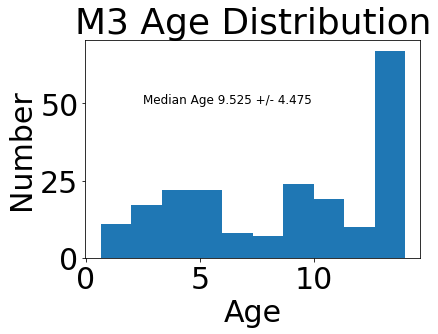

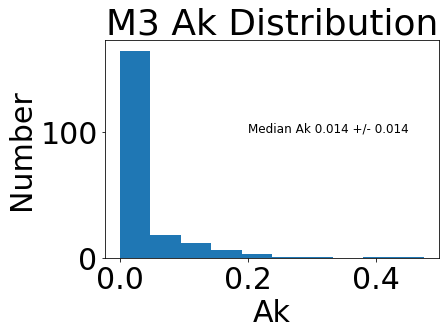

In [31]:
plt.hist(m3ages)
plt.text(2.5,50,'Median Age {:.3f} +/- {:.3f}'.format(np.median(m3ages),mad(m3ages)),fontsize=12)
plt.title(r'M3 Age Distribution')
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.savefig('M3Ages.pdf',bbox_inches='tight')
plt.show()

plt.hist(m3ak)
plt.text(0.2,100,'Median Ak {:.3f} +/- {:.3f}'.format(np.median(m3ak),mad(m3ak)),fontsize=12)
plt.title(r'M3 Ak Distribution')
plt.xlabel(r'Ak')
plt.ylabel(r'Number')
plt.savefig('M3Ak.pdf',bbox_tight='tight')
plt.show()

In [29]:
np.median(gcs['AK_TARG'][m3_idx])

0.004045187

(array([ 36., 135., 243., 275., 295., 280., 355., 286., 137.,  12.]),
 array([1.842015 , 1.8786652, 1.9153153, 1.9519655, 1.9886155, 2.0252657,
        2.0619159, 2.098566 , 2.135216 , 2.1718662, 2.2085164],
       dtype=float32),
 <a list of 10 Patch objects>)

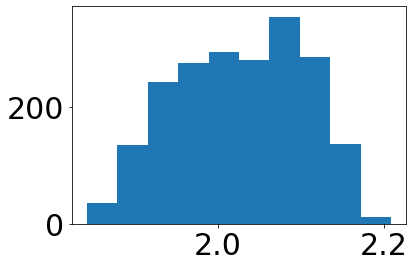

In [68]:
plt.hist(np.log10(gcs['TEFF_ERR']))

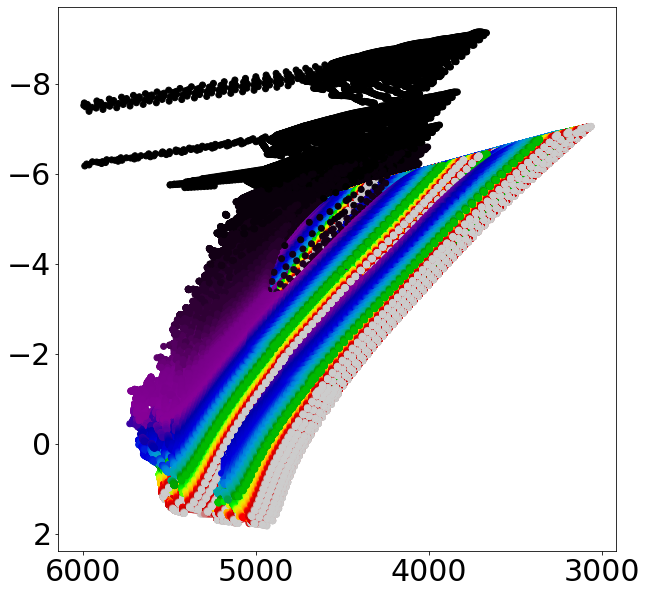

In [63]:
teff_cut = np.where(10**massive['logTe']<6000)
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][teff_cut],massive['Ksmag'][teff_cut],c=10**massive['logAge'][teff_cut]/10**9,
            cmap='nipy_spectral')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

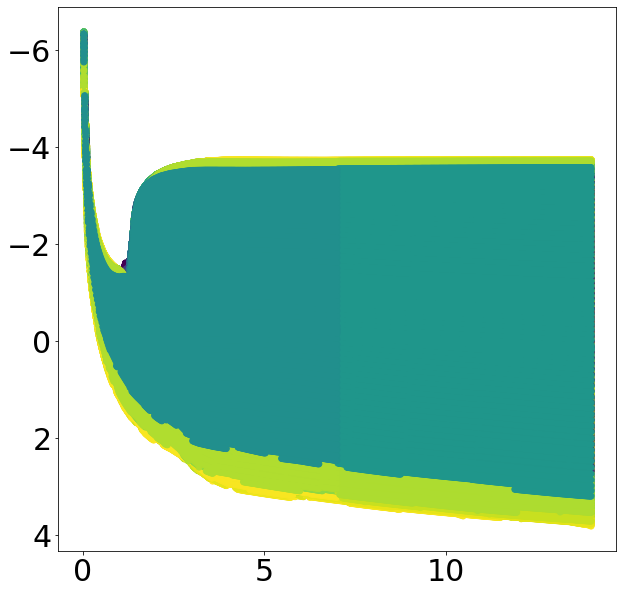

In [45]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logAge']/10**9,massive['mbolmag'],c=massive['MH'])
plt.gca().invert_yaxis()

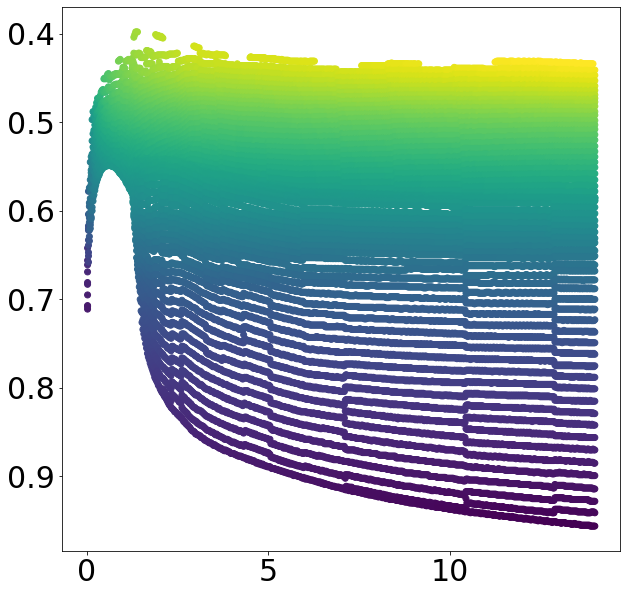

In [54]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    ------
        value in dat closest to val
    '''
    #val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

closest((gcs['M_H']+np.log10(0.638*(10**gcs['ALPHA_M'])+0.362))[g_idx],massive['MH'])

met = np.where(massive['MH']==-1.29)

plt.figure(figsize=[10,10])
plt.scatter(10**massive['logAge'][met]/10**9,(massive['Jmag']-massive['Ksmag'])[met],c=massive['logg'][met])
plt.gca().invert_yaxis()

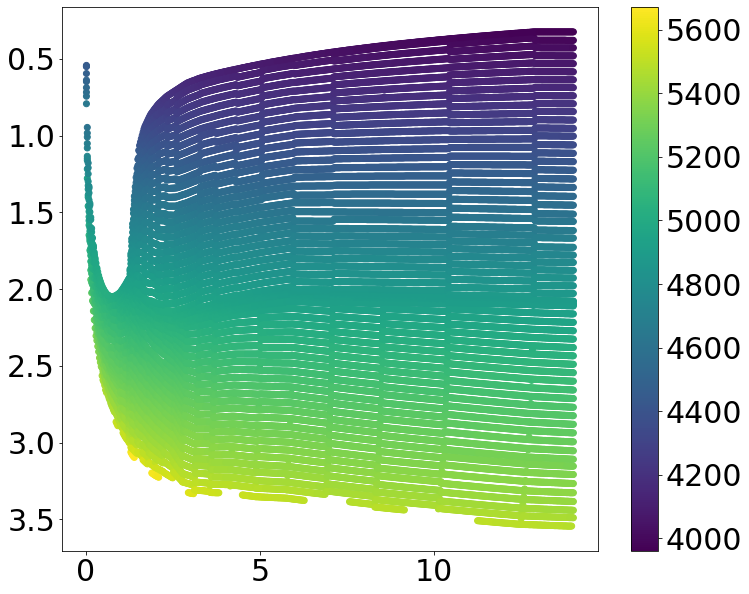

In [60]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logAge'][met]/10**9,massive['logg'][met],c=10**massive['logTe'][met])
plt.colorbar()
plt.gca().invert_yaxis()

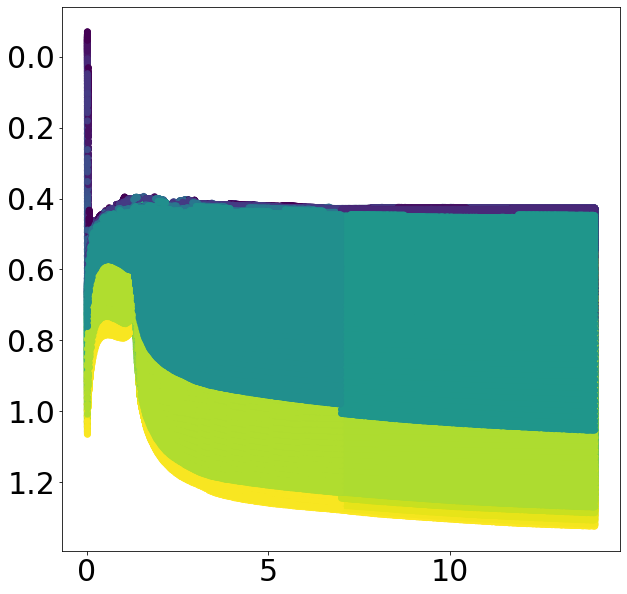

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logAge']/10**9,massive['Jmag']-massive['Ksmag'],c=massive['MH'])
plt.gca().invert_yaxis()

In [ ]:
# # pick star
# g_idx2 = 1500

# # initialize class
# CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx2],gcs['ALPHA_M'][g_idx2],6400,massive)

# # curve_fit does its thing
# popt, pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][g_idx2],
#                          np.array([[gcs['J'][g_idx2],gcs['H'][g_idx2],gcs['K'][g_idx2]]],dtype=float).T.ravel(),
#                          p0=[7.,gcs['AK_TARG'][g_idx2]],bounds=((0.,0.),(14.,1.)),method='dogbox')


# print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx2],gcs['H'][g_idx2],gcs['K'][g_idx2]))
# print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx2]))
# print('Final Calculated [Age, Ak]:',popt)

In [ ]:
### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [ ]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    ------
        value in dat closest to val
    '''
    #val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def parsec_teff2mag(teff,feh,band,age,isochrones):
    '''
    Calculate the intrinsic magnitude from a star's given temperture and metallicity using PARSEC isochrones
    
    Inputs:
    ------
        teff: temperature of star
        feh: metallicity of star
        band: [str] magnitude
        age: age in Gyr to use 
        isochrones: set of parsec isochrones
    Output:
    ------
        mag: expected intrinsic magnitude for the given temperature
    '''
    
    single = isochrones[np.where((isochrones['logAge']==closest(np.log10(age*10**9),isochrones['logAge']))&
                                 (isochrones['MH']==closest(feh,isochrones['MH'])))]
    
    sidx = np.argsort(single['logTe'])
    slogTe = single['logTe'][sidx]
    smag = single[band][sidx]

    _, ui = np.unique(slogTe,return_index=True)
    
    try:
        if np.log10(teff) > min(slogTe):
            spl = InterpolatedUnivariateSpline(slogTe[ui],smag[ui])
    
            mag = spl(np.log10(teff))
            return mag
        
        else:
            return -9999.0
    
    except:
        return -9999.0
    
def interp_MagAge(mags,ages):
    '''
    Interpolate ages as a function of magnitudes
    
    Inputs:
    ------
        mags: magnitudes
        ages: ages
        
    Outputs:
    -------
        spl: return scipy.interpolate.fitpack2.InterpolatedUnivariateSpline
    '''
    mags = np.asarray(mags)
    ages = np.asarray(ages)
    
    cut = np.where(mags!=-9999.0)
    
    sidx = np.argsort(mags[cut])
    smags = mags[cut][sidx]
    sages = ages[cut][sidx]
    
    try:
        spl = InterpolatedUnivariateSpline(smags,sages)
        return spl
    
    except:
        return -9999.0
    
def absMag(mag,dist,extinction):
    '''
    Calculate the absolute magnitude of a star
    
    Inputs:
    ------
        mag: apparent magnitude of star
        dist: distance in pc
        extinction: extinction in band of interest
        
    Output:
    ------
        amag: absolute magnitude
    '''
    amag = mag-5*np.log10(dist)+5-extinction
    return amag

In [ ]:
g_idx = 1000
g_idx2 = 1500

# mag_interpbp = []
# mag_interpg = []
# mag_interprp = []
mag_interpj = []
mag_interph = []
mag_interpk = []

mag_interpj2 = []
mag_interph2 = []
mag_interpk2 = []

for i in tqdm_notebook(10**np.unique(massive['logAge'])/10**9):
#     mag_interpbp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag',i,massive))
#     mag_interpg.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag',i,massive))
#     mag_interprp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_RPmag',i,massive))
    mag_interpj.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag',i,massive))
    mag_interph.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Hmag',i,massive))
    mag_interpk.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Ksmag',i,massive))
    mag_interpj2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag',i,massive))
    mag_interph2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Hmag',i,massive))
    mag_interpk2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Ksmag',i,massive))
    

# ebprp = (gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
#          extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag','G_RPmag',12.5,massive))

# egrp = (gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
#          extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag','G_RPmag',12.5,massive))

ejh = (gcs['J'][g_idx]-gcs['H'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Hmag',12.5,massive))

ejk = (gcs['J'][g_idx]-gcs['K'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Ksmag',12.5,massive))

ejh2 = (gcs['J'][g_idx2]-gcs['H'][g_idx2]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag','Hmag',12.5,massive))

ejk2 = (gcs['J'][g_idx2]-gcs['K'][g_idx2]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag','Ksmag',12.5,massive))

In [ ]:
### Denissenkov et al. 2017

# abp_g_idx = ebprp*extinct.cardelli_alav(leff['BP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
# ag_g_idx = ebprp*extinct.cardelli_alav(leff['G'],3.1)/extinct.cardelli_e12av(leff['G'],leff['RP'],3.1)
# arp_g_idx = ebprp*extinct.cardelli_alav(leff['RP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
# aj_g_idx = ejh*extinct.cardelli_alav(leff['J'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
# ah_g_idx = ejh*extinct.cardelli_alav(leff['H'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
ak_g_idx = ejk*extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)
ak_g_idx2 = ejk2*extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)

plt.figure(figsize=[20,20])
# plt.plot(mag_interpbp,(10**np.unique(massive['logAge'])/10**9),label='BP',lw=3.0)
# plt.plot(mag_interpg,(10**np.unique(massive['logAge'])/10**9),label='G',lw=3.0)
# plt.plot(mag_interprp,(10**np.unique(massive['logAge'])/10**9),label='RP',lw=3.0)
# plt.plot(mag_interpj,(10**np.unique(massive['logAge'])/10**9),label='J',lw=3.0)
# plt.plot(mag_interph,(10**np.unique(massive['logAge'])/10**9),label='H',lw=3.0)
plt.plot(mag_interpk,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0,c='tab:red')
plt.plot(mag_interpk2,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0,c='tab:blue')

plt.axhline(12.6,c='red')
plt.axhline(13.95,c='tab:blue')
plt.axhline(6.58263274,c='tab:red',ls='--')
plt.axhline(1.64998445,c='tab:blue',ls='--')
# plt.legend()
# plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-15.02-abp_g_idx,c='tab:blue',ls=':',lw=3.0)
# plt.axvline(gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-15.02-ag_g_idx,c='tab:orange',ls=':',lw=3.0)
# plt.axvline(gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-15.02-arp_g_idx,c='tab:green',ls=':',lw=3.0)
# plt.axvline(gcs['J'][g_idx]-15.02-aj_g_idx,c='tab:red',ls=':',lw=3.0)
# plt.axvline(gcs['H'][g_idx]-15.02-ah_g_idx,c='tab:purple',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-15.02-ak_g_idx,c='tab:red',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx2]-5*np.log10(6400)+5.0-ak_g_idx2,c='tab:blue',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-5*np.log10(10400)+5.0-0.02678748,c='tab:red',ls='--',lw=3.0)
plt.axvline(gcs['K'][g_idx2]-5*np.log10(6400)+5.0-0.19425305,c='tab:blue',ls='--',lw=3.0)

plt.xlim(-6,1)
plt.grid()
# plt.title(r'Denissenkov et al. 2017')
plt.xlabel(r'Magnitude')
plt.ylabel(r'Age in Gyr')
plt.show()

In [ ]:
gcs['K'][g_idx]-5*np.log10(10400)-5.0#-0.02678748

In [ ]:
gcs['K'][g_idx]-5*np.log10(10400)+5.0-0.02678748